[*********************100%***********************]  1 of 1 completed


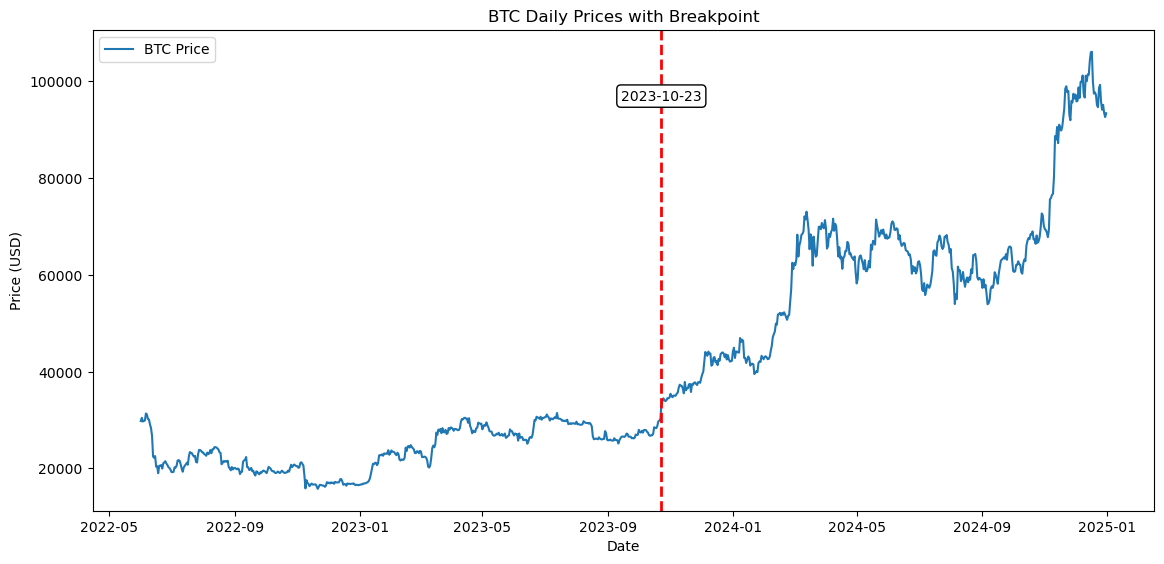

,Start,End,Mean Return (%),Daily Volatility (%)
0,2022-06-01,2023-10-23,Ticker BTC-USD 0.058043 dtype: float64,Ticker BTC-USD 2.730254 dtype: float64
1,2023-10-24,2024-12-31,Ticker BTC-USD 0.275218 dtype: float64,Ticker BTC-USD 2.709825 dtype: float64


In [1]:
import yfinance as yf
import ruptures as rpt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1) Download Data
# ---------------------------------------------------------------------
btc_data = yf.download('BTC-USD', start='2022-6-01', end='2025-1-1')
btc_close = btc_data['Close']

# Calculate daily returns
btc_returns = btc_close.pct_change().dropna()

# ---------------------------------------------------------------------
# 2) Detect Exactly ONE Breakpoint Using Binseg
# ---------------------------------------------------------------------
model = "rank"  # more stable and good for the volatile BTC 
algo = rpt.Binseg(model=model).fit(btc_close.values)

# We want exactly ONE breakpoint => n_bkps=1 => 2 segments
# result will be [break_index, len(btc_close)]
result = algo.predict(n_bkps=1)

# ---------------------------------------------------------------------
# 3) Plot the Single Breakpoint (Using r-1)
# ---------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(btc_close.index, btc_close.values, label='BTC Price')

# The first element of result is the break index
break_index = result[0]

# We'll label the vertical line at r-1 (last day of old regime)
for pt in result[:-1]:
    break_line_date = btc_close.index[pt - 1]  # SHIFT by -1
    plt.axvline(x=break_line_date, color='r', linestyle='--', lw=2)
    plt.text(
        break_line_date,
        max(btc_close.values) * 0.9,
        str(break_line_date.date()),
        color='black',
        rotation=0,
        verticalalignment='bottom',
        horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.title('BTC Daily Prices with Breakpoint')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout(pad=2)
plt.show()

# ---------------------------------------------------------------------
# 4) Create Two Zones: Before/After the Break (using r-1)
# ---------------------------------------------------------------------
# Since we labeled r-1 in the plot, 
#    Zone 1 ends on break_index-1  (old regime)
#    Zone 2 starts on break_index  (new regime)
zone_data = []

# Zone 1: from the start to break_index-1
zone1_start = btc_close.index[0]
zone1_end   = btc_close.index[break_index - 1]
zone1_returns = btc_returns[zone1_start:zone1_end]

zone_data.append([
    zone1_start, 
    zone1_end, 
    zone1_returns.mean() * 100,  # mean return (%)
    zone1_returns.std()  * 100   # volatility (%)
])

# Zone 2: from break_index to the end
zone2_start = btc_close.index[break_index]
zone2_end   = btc_close.index[-1]
zone2_returns = btc_returns[zone2_start:zone2_end]

zone_data.append([
    zone2_start, 
    zone2_end, 
    zone2_returns.mean() * 100,  # mean return (%)
    zone2_returns.std()  * 100   # volatility (%)
])

# Convert zone stats to DataFrame
zones_df = pd.DataFrame(
    zone_data, 
    columns=['Start', 'End', 'Mean Return (%)', 'Daily Volatility (%)']
)

zones_df
